# Monte Carlo Simulations with GARCH

The following analysis is based on content from Lecture on Volatility Models from the *Analytics of Finance* course by Leonid Kogan at MIT Sloan OpenCourseWare (OCW).  
Monte Carlo simulations are useful to investigate the statistical properties of GARCH models. They help assess the performance of common estimation methods such as Maximum Likelihood Estimation (MLE) and Quasi-Maximum Likelihood Estimation (QMLE). 

The original lecture slides can be downloaded from MIT Sloan OpenCourseWare at: [MIT Sloan OCW - Analytics of Finance (Lecture 10)](https://ocw.mit.edu/courses/15-450-analytics-of-finance-fall-2010/resources/mit15_450f10_lec10/)

### Brief Guide to the Notebook

Data is either downloaded directly from Yahoo Finance or generated through simulations, so no CSV files are required. The theory is briefly introduced each time, making the notebook self-contained and easy to follow. Users can modify key parameters, such as model specifications, time periods, and the number of simulations, to explore different scenarios. The notebook should be run sequentially; using "Run All" is recommended to ensure consistency in results.  

### Libraries

In [24]:
# Uncomment the following lines to install the required libraries if they are not already installed
#!pip install numpy
#!pip install matplotlib
#!pip install yfinance
#!pip install pandas
#!pip install scipy
#!pip install tabulate
#!pip install arch

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats import t as student_t, norm
from tabulate import tabulate
from arch import arch_model
from scipy.special import gammaln

### Key Notations

Before introducing Monte Carlo simulations, GARCH dynamics and notations will be reintroduced.
To align with the notation used in the slides and avoid confusion, we will use the same symbols and conventions.

The time series $z_t$ represents the log changes in daily spot index levels:

$$
z_t = \ln \left( \frac{P_t}{P_{t-1}} \right)
$$

where:
- $P_t$ is the spot index level at time $t$
- $P_{t-1}$ is the spot index level at time $t-1$

To analyze the series without the influence of its mean, we construct the demeaned time series $x_t$ as:

$$
x_t = z_t - \hat{\mathbb{E}}[z_t]
$$

### Dynamics of GARCH(1,1)

As a reminder, the GARCH(1,1) model describes the evolution of conditional variance and returns.

Conditional variance:  
$$
\sigma_t^2 = a_0 + a_1 x_{t-1}^2 + b_1 \sigma_{t-1}^2
$$

Returns:  
$$
x_t = \sigma_t \epsilon_t, \quad \epsilon_t \sim N(0, 1), \, \text{i.i.d.}
$$

Stable dynamics require:  
$$
a_1 + b_1 < 1
$$

As the forecast horizon increases, the conditional variance converges to:  
$$
\lim_{n \to \infty} \mathbb{E}_t[\sigma_{t+n}^2] = \frac{a_0}{1 - a_1 - b_1}
$$

Since $\mathbb{E}[x_{t+1}^2] = a_0 + a_1 \mathbb{E}[x_t^2] + b_1 \mathbb{E}[\sigma_t^2]$, we now obtain the average conditional variance formula:  
$$
\mathbb{E}[x_t^2] = \frac{a_0}{1 - a_1 - b_1}
$$

---
### Monte Carlo Experiment for GARCH(1,1) Process

Monte Carlo simulations work by repeatedly generating random samples from a model to approximate its statistical properties. Here, they help us investigate the distributional properties of a GARCH(1,1) process and compare them with those of a normal distribution and real financial data (S&P 500). It is immediate to see how Monte Carlo is very convenient here, as it allows us to explore these properties without relying on additional mathematics.  

### Tail Probability Comparison  
We specifically compare the tail probabilities:  
$$
P\left( \frac{x_t}{\sqrt{E[x_t^2]}} > k \right)
$$   
for $k = 1, 2, 3, 4$, with:  
- GARCH(1,1) tail probabilities estimated from simulations
- Gaussian probabilities from the standard normal distribution
- S&P 500 empirical tail probabilities computed from daily log returns

Here, $\sqrt{E[x_t^2]}$ represents the standard deviation when the mean of $x_t$ is zero (which is how we defined $x$ before). For the calculation either the empirical standard deviation or the square root of the unconditional variance can be used, as they converge to the same value due to the Law of Large Numbers (LLN).
The parameter $k$ represents how much of the data lies beyond $1$, $2$, $3$, or $4$ standard deviations. A higher probability at larger $k$ values indicates heavier tails. 

### Monte Carlo Design  
The setting is the following:
- Simulate $100,000$ observations of the GARCH(1,1) process with:  
  $$
  a_0 = 1, \quad a_1 = 0.1, \quad b_1 = 0.8
  $$  
- The initial variance is set using the unconditional variance formula we just obtained:  
  $$
  \sigma_1^2 = \frac{a_0}{1 - a_1 - b_1}
  $$
- Discard the first $10\%$ of observations (burn-in sample)  
- Analyze the unconditional distribution of the remaining sample  
- Standardize all values for a fair comparison
- Compute and compare tail probabilities with Gaussian expectations and S&P500 daily log returns  

A plot of the first 1000 steps of a subset of 30 Monte Carlo simulations is constructed for better clarity.

### Findings  
The results confirm that on average the GARCH(1,1) simulated data (or unconditional distribution of $x_t$) has heavier tails than the Gaussian distribution, but the S&P500 data exhibits even more extreme tail behavior. At the same time, real financial returns are more concentrated near the center, making them skinnier around the mean. These findings are supported both by a constructed table and an intuitive histogram, which is centered for better readability. While asymmetry is not considered here, it is clearly present in financial returns.

In [26]:
# Set random seed for reproducibility
np.random.seed(123)

# Parameters
n_obs = 100000        # Total observations
burn_in = int(0.1 * n_obs)  # Burn-in (10% of observations)
a0 = 1                # GARCH(1,1) parameter
a1 = 0.1             # GARCH(1,1) parameter
b1 = 0.8            # GARCH(1,1) parameter
n_simulations = 1000   # Number of Monte Carlo simulations

# Initialize arrays to store multiple simulations
simulated_paths = []

# Simulate multiple GARCH(1,1) processes
for sim in range(n_simulations):
    sigma2 = np.zeros(n_obs)
    x_t = np.zeros(n_obs)

    # Initial variance
    sigma2[0] = a0 / (1 - a1 - b1)

    # Simulate GARCH(1,1) process
    for t in range(1, n_obs):
        epsilon_t = np.random.normal(0, 1)
        sigma2[t] = a0 + a1 * x_t[t-1]**2 + b1 * sigma2[t-1]
        x_t[t] = np.sqrt(sigma2[t]) * epsilon_t

    # Remove burn-in sample
    simulated_paths.append(x_t[burn_in:])

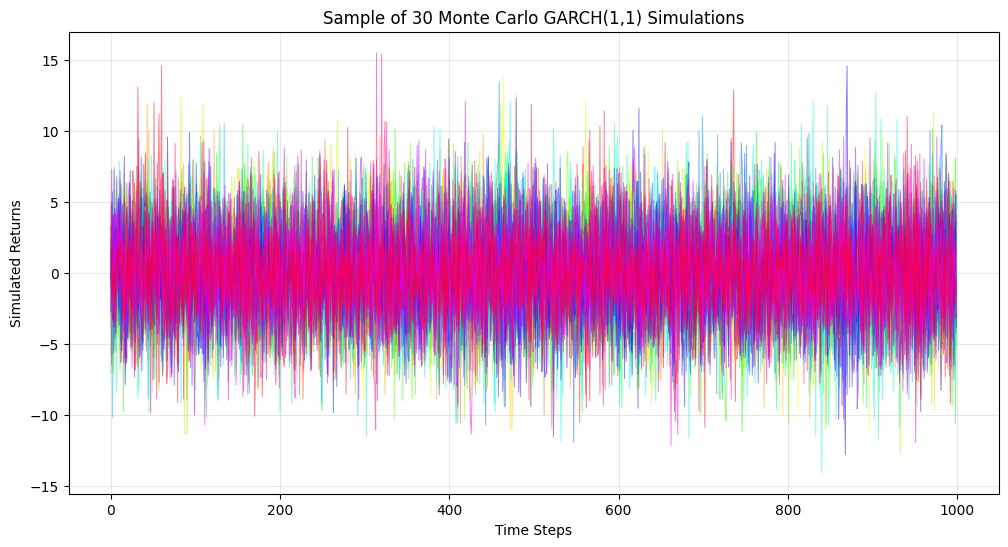

In [27]:
# Plot a sample of Monte Carlo simulations
plt.figure(figsize=(12, 6))
colors = plt.cm.hsv(np.linspace(0, 1, 30))  # 30 distinct colors
for path, color in zip(simulated_paths[:30], colors):  # Plot only 30 simulations
    plt.plot(path[:1000], alpha=0.5, color=color, linewidth=0.7)
plt.title("Sample of 30 Monte Carlo GARCH(1,1) Simulations")
plt.xlabel("Time Steps")
plt.ylabel("Simulated Returns")
plt.grid(alpha=0.3)
plt.show()

In [28]:
# Concatenate all values from all simulation paths (after burn-in)
all_values_simulated = np.concatenate(simulated_paths)

# Standardize the final values
simulations_standardized = (all_values_simulated - np.mean(all_values_simulated)) / np.std(all_values_simulated)

# Download S&P 500 data from Yahoo Finance
sp500 = yf.download("^GSPC", start="2004-01-01", end="2010-01-01", multi_level_index=False) 
sp500["Returns"] = np.log(sp500["Close"] / sp500["Close"].shift(1))  # Log-returns

# Drop Na values from the entire DF 
sp500.dropna(inplace=True)

# Standardize S&P returns by standard deviation for tail probability comparison
sp500_std = np.std(sp500["Returns"])
sp500_returns_standardized = (sp500["Returns"] - np.mean(sp500["Returns"])) / sp500_std

# Tail probabilities comparison using standardized GARCH data
k_values = [1, 2, 3, 4]
tail_probabilities_garch = [np.mean(np.abs(simulations_standardized) > k) for k in k_values]
tail_probabilities_gaussian = [2 * (1 - norm.cdf(k)) for k in k_values]
tail_probabilities_sp500 = [np.mean(np.abs(sp500_returns_standardized) > k) for k in k_values]

# Tail probability results
table_data = [
    [k, f"{garch_prob:.4f}", f"{gauss_prob:.4f}", f"{sp500_prob:.4f}"]
    for k, garch_prob, gauss_prob, sp500_prob in zip(k_values, tail_probabilities_garch, tail_probabilities_gaussian, tail_probabilities_sp500)
]

# Print table using tabulate for better formatting
print("\nTail Probabilities for Standardized Data (GARCH vs Gaussian vs S&P 500):\n")
print(tabulate(table_data, headers=["k", "GARCH", "Gaussian", "S&P 500"], tablefmt="fancy_grid", numalign="right"))

[*********************100%***********************]  1 of 1 completed



Tail Probabilities for Standardized Data (GARCH vs Gaussian vs S&P 500):

╒═════╤═════════╤════════════╤═══════════╕
│   k │   GARCH │   Gaussian │   S&P 500 │
╞═════╪═════════╪════════════╪═══════════╡
│   1 │  0.3064 │     0.3173 │    0.1629 │
├─────┼─────────┼────────────┼───────────┤
│   2 │  0.0471 │     0.0455 │    0.0536 │
├─────┼─────────┼────────────┼───────────┤
│   3 │  0.0047 │     0.0027 │    0.0212 │
├─────┼─────────┼────────────┼───────────┤
│   4 │  0.0004 │     0.0001 │    0.0099 │
╘═════╧═════════╧════════════╧═══════════╛


**Note on Yahoo Finance Update (Feb 2025)**  
- New Multi-Index Column Structure: Data now has a two-level column format.  
- Price Adjustments: "Close" is now fully adjusted for splits and dividends.  
- Key Change: Previously, we needed "Adj Close" for total return calculations, now "Close" suffices.  

If you prefer the old data structure, set `multi_level_index=False` when downloading data. If you want non-adjusted prices, set `auto_adjust=False` to retrieve raw closing prices.

In [29]:
# Calculate theoretical unconditional standard deviation from GARCH(1,1)
unconditional_std = np.sqrt(a0 / (1 - a1 - b1))

# Calculate empirical standard deviation from the simulated GARCH paths
empirical_std = np.std(all_values_simulated)

# Print and compare
print(f"Theoretical Unconditional Std Dev (GARCH): {unconditional_std:.6f}")
print(f"Empirical Std Dev (From Simulated Data): {empirical_std:.6f}")
print(f"Difference: {np.abs(unconditional_std - empirical_std):.6f}")

Theoretical Unconditional Std Dev (GARCH): 3.162278
Empirical Std Dev (From Simulated Data): 3.161813
Difference: 0.000465


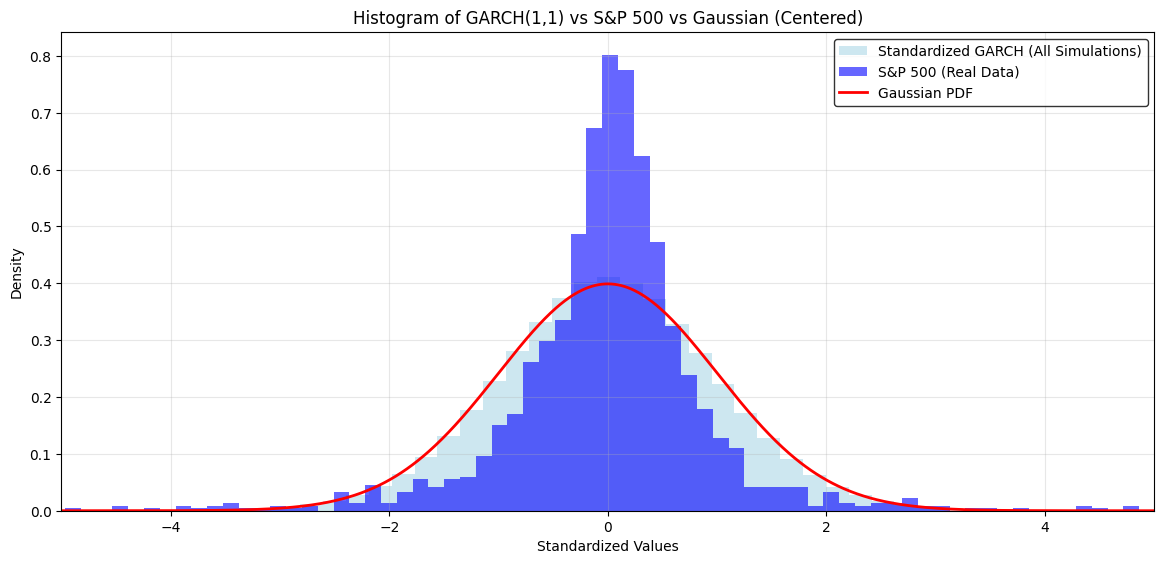

In [30]:
# Histogram of Tails for Standardized GARCH Simulations
plt.figure(figsize=(12, 6))  

# Plot GARCH Simulations
plt.hist(
    simulations_standardized, 
    bins=100, 
    density=True, 
    alpha=0.6, 
    label='Standardized GARCH (All Simulations)', 
    color='lightblue'
)

# Plot S&P 500 Real Returns
plt.hist(
    sp500_returns_standardized, 
    bins=100, 
    density=True, 
    alpha=0.6, 
    label='S&P 500 (Real Data)', 
    color='blue'
)

# Gaussian PDF for comparison
x = np.linspace(-5, 5, 1000)
plt.plot(
    x, 
    norm.pdf(x), 
    label='Gaussian PDF', 
    color='red', 
    linewidth=2
)

# Titles and labels
plt.title(
    "Histogram of GARCH(1,1) vs S&P 500 vs Gaussian (Centered)", 
)

plt.xlabel("Standardized Values")
plt.ylabel("Density")

# Centering the plot limits
plt.xlim(-5, 5)  # Set x-axis to symmetrical range
plt.ylim(0, None)  # Let y-axis auto-adjust

# Restoring normal grid
plt.grid(alpha=0.3, linestyle='-')  # Normal, softer grid lines

# Place legend inside the box (to the left or right)
plt.legend(
    loc='upper right',  # You can switch 'upper left' or 'upper right'
    frameon=True, 
    facecolor='white', 
    edgecolor='black'
)

# Improved layout for better spacing
plt.tight_layout(pad=2)

plt.show()

### MLE for GARCH(1,1) 

Maximum Likelihood Estimation (MLE) is used to estimate GARCH(1,1) parameters by maximizing the conditional log-likelihood function. 

We first form the log-likelihood function:  
$$
L(\theta) = \sum_{t=1}^{T} \ln p(x_t \mid \sigma_t; \theta)
$$  

Where $p(x_t \mid\sigma_t;\theta)$ is the normal density:  
$$
p(x_t \mid \sigma_t; \theta) = \frac{1}{\sqrt{2\pi\sigma_t^2}} \exp\left( -\frac{x_t^2}{2\sigma_t^2} \right)
$$  

Under the normality assumption, the log-likelihood for GARCH(1,1) is:  
$$
L(\theta) = \sum_{t=1}^{T} \left[ -\frac{1}{2} \ln(2\pi) - \frac{1}{2} \ln(\sigma_t^2) - \frac{x_t^2}{2\sigma_t^2} \right]
$$  

We estimate parameters $a_0$, $a_1$, and $b_1$ subject to stationarity constraints:  
$$
a_1 \geq 0, \quad b_1 \geq 0, \quad a_1 + b_1 < 1
$$  

**Note**: Standard Errors (SE) are not covered here and neither in the following Monte Carlo experiment.

### Example with S&P 500 

In Python the arch package automatically deals with this series of operations, and can be used to obtain the parameter estimates. We show one example using the previously downloaded (and now scaled) S&P 500 data.

From the GARCH(1,1) fit to the scaled log S&P 500 returns, we obtain:  
- $a_1 = 0.068036$  
- $b_1 = 0.923046$  

The results show high persistence, indicating significant volatility clustering.

### Tail Probability Comparison

The fitted errors (or estimated innovations) are analyzed, $\hat{\epsilon}_t = \frac{x_t}{\hat{\sigma}_t}$, to compare their tails against a Gaussian distribution. The table below shows the proportion of values exceeding $k$ standard deviations:

$$
P(\hat{\epsilon}_t > k)
$$  

### Findings

A table and a histogram are used again to illustrate the results:

- For $k = 3$ the fitted errors conform better to the Gaussian distribution compared to the unconditional distribution of $x_t$ 
- For the S&P 500 data, the heavy tails in the unconditional distribution of daily returns can be attributed to conditional heteroscedasticity 

**Note**: Returns are scaled by 100 for better convergence (otherwise, Python would typically raise a warning). This scaling also allows log returns to be interpreted as percentage changes, which can be justified using a Taylor expansion. However, this approximation is only valid for small changes. Naturally, conditional volatility scales accordingly.


a1: 0.068036
b1: 0.923046


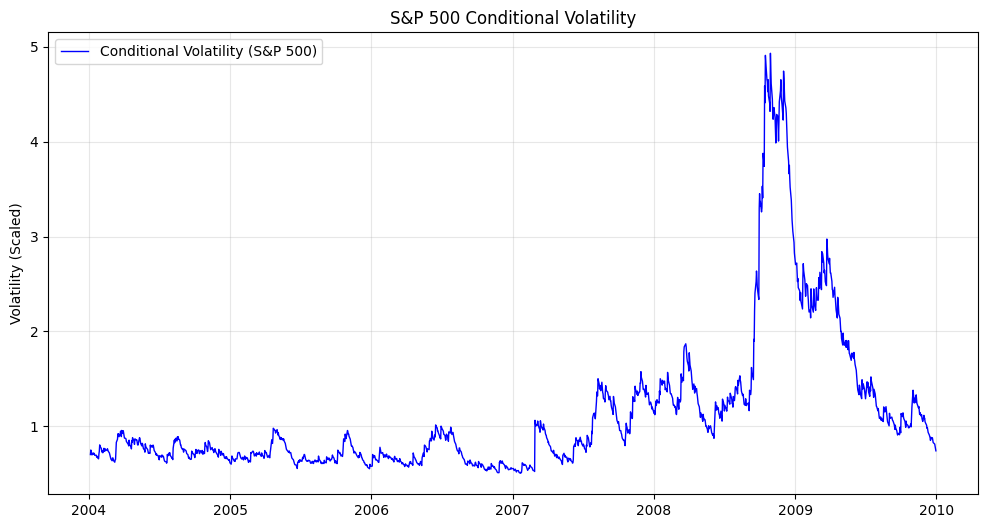

In [31]:
# Use existing cleaned S&P 500 returns 
scaled_returns = (sp500["Returns"] - np.mean(sp500["Returns"])) * 100  # Scale as recommended for numerical stability

# Fit GARCH(1,1) Model
garch_model = arch_model(scaled_returns, vol='Garch', p=1, q=1, dist='normal', rescale=True)
garch_fit = garch_model.fit(disp="off", options={"maxiter": 500, "ftol": 1e-6})

# Print Only a1 and b1
a1 = garch_fit.params["alpha[1]"]
b1 = garch_fit.params["beta[1]"]
print(f"\na1: {a1:.6f}")
print(f"b1: {b1:.6f}")

# Plot Conditional Volatility in Blue
conditional_vol = garch_fit.conditional_volatility
plt.figure(figsize=(12, 6))
plt.plot(conditional_vol, label="Conditional Volatility (S&P 500)", color="blue", linewidth=1)
plt.title("S&P 500 Conditional Volatility")
plt.ylabel("Volatility (Scaled)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [32]:
# Compute Fitted Errors
fitted_errors = scaled_returns / garch_fit.conditional_volatility

# Compute Tail Probabilities
k_values = [1, 2, 3, 4]
tail_probs_errors = [np.mean(np.abs(fitted_errors) > k) for k in k_values]
tail_probs_gaussian = [2 * (1 - norm.cdf(k)) for k in k_values]

# Create and Display Tail Probability Table
errors_table = [
    [k, f"{fitted:.4f}", f"{gaussian:.4f}"]
    for k, fitted, gaussian in zip(k_values, tail_probs_errors, tail_probs_gaussian)
]

print("\nTail Probabilities for Fitted Errors vs Gaussian:")
print(tabulate(errors_table, headers=["k", "Fitted Errors", "Gaussian"], tablefmt="fancy_grid"))


Tail Probabilities for Fitted Errors vs Gaussian:
╒═════╤═════════════════╤════════════╕
│   k │   Fitted Errors │   Gaussian │
╞═════╪═════════════════╪════════════╡
│   1 │          0.294  │     0.3173 │
├─────┼─────────────────┼────────────┤
│   2 │          0.057  │     0.0455 │
├─────┼─────────────────┼────────────┤
│   3 │          0.0033 │     0.0027 │
├─────┼─────────────────┼────────────┤
│   4 │          0.0007 │     0.0001 │
╘═════╧═════════════════╧════════════╛


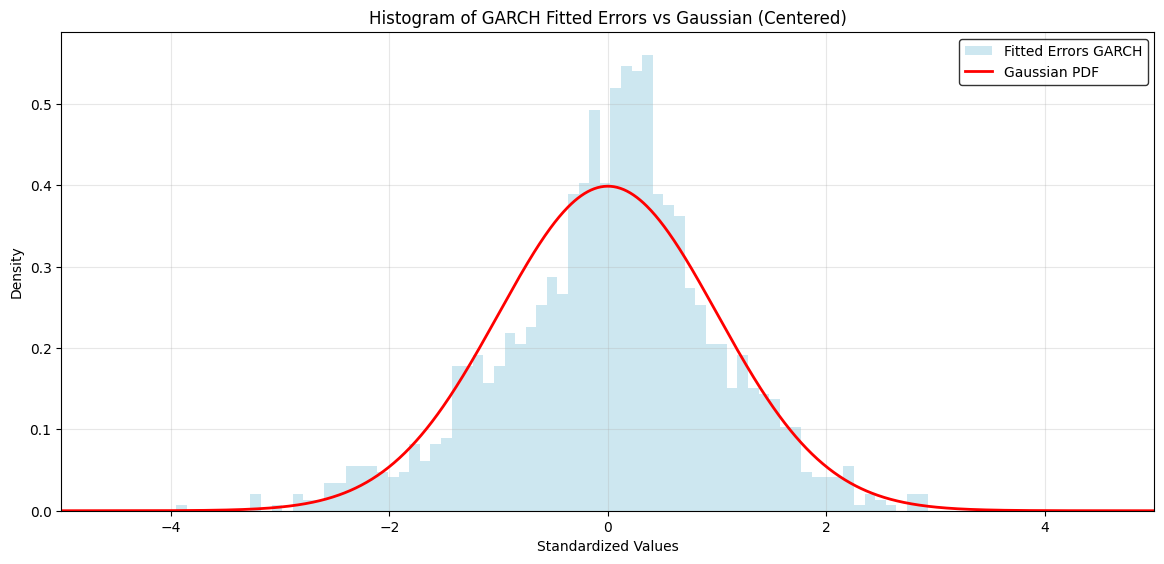

In [33]:
# Plot Histogram of Tails for GARCH Fitted Errors
plt.figure(figsize=(12, 6))

# Plot GARCH Fitted Errors 
plt.hist(
    fitted_errors, 
    bins=100, 
    density=True, 
    alpha=0.6, 
    label="Fitted Errors GARCH", 
    color="lightblue"
)

# Gaussian PDF for comparison
x = np.linspace(-5, 5, 1000)
plt.plot(
    x, 
    norm.pdf(x), 
    label="Gaussian PDF", 
    color="red", 
    linewidth=2
)

# Titles and labels
plt.title("Histogram of GARCH Fitted Errors vs Gaussian (Centered)")
plt.xlabel("Standardized Values")
plt.ylabel("Density")

# Centering the plot limits
plt.xlim(-5, 5)
plt.ylim(0, None)

# Grid and Legend
plt.grid(alpha=0.3, linestyle='-')
plt.legend(
    loc='upper right',
    frameon=True, 
    facecolor='white', 
    edgecolor='black'
)

# Improved layout
plt.tight_layout(pad=2)

plt.show()

### Non-Gaussian Errors for GARCH

Standard GARCH models assume that the errors $\epsilon_t$ are Gaussian. However, real financial data often exhibits fat tails, meaning that large shocks are more frequent than a normal distribution would predict.  

Returns are still modeled as:  
$$
x_t = \sigma_t \epsilon_t, \quad \mathbb{E}[\epsilon_t] = 0, \quad \mathbb{E}[\epsilon_t^2] = 1
$$  

Two approaches are used when the errors are non-Gaussian:  

- QMLE (Quasi-Maximum Likelihood Estimation), which assumes Gaussian errors but remains robust even if the actual errors are non-Gaussian 
- MLE with an alternative error distribution to account for the heavy tails (such as Student's t, GED, etc.)

### QMLE  
The QMLE method maximizes the log-likelihood function under the assumption of Gaussian errors. We keep using the objective function:  
$$
L(\theta) = \sum_{t=1}^{T} \left[ -\frac{1}{2} \ln(2\pi) - \ln(\sigma_t) - \frac{x_t^2}{2\sigma_t^2} \right]
$$  

Now consider the function:
$$
f(x) = -\ln(x) - \frac{a}{x}, \quad \text{maximized at } x = a
$$

Similarly, in the context of GARCH, consider the conditional expectation:  
$$
\mathbb{E}\left[ \frac{x_t^2}{\sigma_t^2(\theta)} - \ln(\sigma_t^2(\theta)) \right], \quad \text{maximized at the true parameter values } \theta_0
$$

This implies that $\theta_0$ maximizes the unconditional expectation as well; it follows that we can estimate it by maximizing the Gaussian log-likelihood function. 

### Student's t Shocks  
Another popular alternative is to just assume a Student's t error distribution, and calculate the MLE given this new assumption. The probability density function (PDF) of a Student’s t-distribution with $\nu$ degrees of freedom is:  
$$
p(\epsilon_t; \nu) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi(\nu-2)}} \left( 1 + \frac{\epsilon_t^2}{\nu - 2} \right)^{-\frac{\nu+1}{2}}, \quad \nu > 2
$$  
where:  
- $\Gamma(\cdot)$ is the Gamma function:  
  $$
  \Gamma(x) = \int_0^\infty z^{x-1} e^{-t} \, dz
  $$  
- $\nu$ is the degrees of freedom, which controls the thickness of the tails

The log-likelihood function for GARCH(1,1) under a Student’s t-distribution is:  
$$
L(\theta) = \sum_{t=1}^{T} \left[\ln \Gamma\left(\frac{\nu+1}{2}\right) - \ln \Gamma\left(\frac{\nu}{2}\right) - \frac{1}{2} \ln(\pi(\nu-2)) - \frac{\nu+1}{2} \ln\left(1 + \frac{x_t^2}{\sigma_t^2(\nu-2)}\right) - \frac{1}{2} \ln(\sigma_t^2) \right]
$$  

---

### Monte Carlo Experiment for GARCH with Non-Normal Shocks  

The effectiveness of the QMLE approach in handling non-normal shocks can be evaluated using Monte Carlo experiments. Monte Carlo simulations help us gain intuition about the performance of QMLE and illustrate the typical design of a simulation experiment.  

### Monte Carlo Design  

The Monte Carlo experiment simulates data from a GARCH(1,1) model with the following parameters:  

$$
a_0 = 1, \quad a_1 = 0.05, \quad b_1 = 0.9
$$  

The innovations $\epsilon_t$ are drawn from a standardized Student’s t-distribution with $\nu = 6$ degrees of freedom to introduce non-normality.  

Simulation details:  
- Number of samples ($N$): 1,000  
- Sample length ($T$): 1,000 or 3,000  
- Burn-in period: 500 observations (to eliminate initial value effects)  
- Initial variance:  
$$
\sigma_1^2 = \frac{a_0}{1 - a_1 - b_1}
$$  

From each simulation, we extract estimates $\hat{a}_1$ and $\hat{b}_1$ using both QMLE and MLE (with Student’s t errors) to compare their performance under non-normal conditions..

### Summary Statistics  

To compare the performance of QMLE and MLE, the following statistics are computed across all simulations:  

1. Root-Mean-Squared Error (RMSE): Measures the accuracy of parameter estimates. 
$$
\text{RMSE}(\hat{\theta}) = \sqrt{\frac{1}{N} \sum_{n=1}^{N} (\hat{\theta}_n - \theta_0)^2}
$$  

2. Average Parameter Estimate: Measures the bias by averaging the estimated parameters over all simulations.  
$$
\text{Average}(\hat{\theta}) = \frac{1}{N} \sum_{n=1}^{N} \hat{\theta}_n
$$  

### Findings  

All results are summarized in a table, followed by a plot illustrating the RMSEs. We can observe the following:
- Both QMLE and MLE with Student’s t-distribution produce consistent estimates of the parameters
- At $T = 1,000$, there is a bias in both methods, which disappears when the sample size increases to $T = 3,000$
- MLE with Student’s t-distribution is more efficient than QMLE, producing lower RMSE values
- QMLE is more robust than MLE because it does not rely on the exact distribution of errors

In [34]:
# Set random seed for reproducibility
np.random.seed(123)

# Parameters
N_simulations = 1000  # Number of simulations
burn_in = 500  # Burn-in
a0, a1, b1 = 1, 0.05, 0.9  # True GARCH(1,1) parameters
nu = 6  # Degrees of freedom for Student's t
sample_sizes = [1000, 3000]  # Sample sizes
results = {"T": [], "Method": [], "RMSE_a1": [], "RMSE_b1": [], "Mean_a1": [], "Mean_b1": []}

# Function to generate GARCH(1,1) process
def generate_garch(T, a0, a1, b1, nu):
    sigma2 = np.zeros(T + burn_in)
    x_t = np.zeros(T + burn_in)
    sigma2[0] = a0 / (1 - a1 - b1)
    for t in range(1, T + burn_in):
        epsilon_t = student_t.rvs(df=nu) / np.sqrt(nu / (nu - 2)) # Standardized Student's t-distributed shock (mean 0, variance 1)
        sigma2[t] = a0 + a1 * x_t[t-1]**2 + b1 * sigma2[t-1]
        x_t[t] = np.sqrt(sigma2[t]) * epsilon_t
    return x_t[burn_in:], sigma2[burn_in:]

# Log-likelihood for Gaussian QMLE
def log_likelihood_gaussian(params, x):
    a0, a1, b1 = params
    T = len(x)
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(x)
    for t in range(1, T):
        sigma2[t] = a0 + a1 * x[t-1]**2 + b1 * sigma2[t-1]
    ll = -0.5 * (np.log(2 * np.pi) + np.log(sigma2) + x**2 / sigma2)
    return -np.sum(ll)

# Log-likelihood for Student's t MLE
def log_likelihood_student(params, x, nu):
    a0, a1, b1 = params
    T = len(x)
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(x)
    for t in range(1, T):
        sigma2[t] = a0 + a1 * x[t-1]**2 + b1 * sigma2[t-1]
    ll = (gammaln((nu + 1) / 2)
        - gammaln(nu / 2)
        - 0.5 * np.log(np.pi * (nu - 2))
        - 0.5 * np.log(sigma2)
        - ((nu + 1) / 2) * np.log(1 + (x**2) / ((nu - 2) * sigma2)))
    return -np.sum(ll)

# Optimization function (L-BFGS-B set as default)
def estimate_params(x, method="QMLE"):
    bounds = [(1e-6, None), (1e-6, 1), (1e-6, 1)]  # Parameter bounds
    if method == "QMLE":
        result = minimize(log_likelihood_gaussian, [0.1, 0.1, 0.8], args=(x,), bounds=bounds)
        return result.x
    elif method == "MLE":
        result = minimize(log_likelihood_student, [0.1, 0.1, 0.8], args=(x, nu), bounds=bounds)
        return result.x

# Monte Carlo Experiment 
for T in sample_sizes:
    for method in ["QMLE", "MLE"]:
        estimates_a1 = []
        estimates_b1 = []

        for _ in range(N_simulations):
            # Generate data
            x_t, _ = generate_garch(T, a0, a1, b1, nu)

            # Estimate parameters
            est_params = estimate_params(x_t, method)
            est_a0, est_a1, est_b1 = est_params

            # Store estimates
            estimates_a1.append(est_a1)
            estimates_b1.append(est_b1)

        # Calculate statistics
        rmse_a1 = np.sqrt(np.mean((np.array(estimates_a1) - a1)**2))
        rmse_b1 = np.sqrt(np.mean((np.array(estimates_b1) - b1)**2))
        mean_a1 = np.mean(estimates_a1)
        mean_b1 = np.mean(estimates_b1)

        # Store results
        results["T"].append(T)
        results["Method"].append(method)
        results["RMSE_a1"].append(rmse_a1)
        results["RMSE_b1"].append(rmse_b1)
        results["Mean_a1"].append(mean_a1)
        results["Mean_b1"].append(mean_b1)

# Display Results 
df_results = pd.DataFrame(results)
print(tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False))

╒══════╤══════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│    T │ Method   │   RMSE_a1 │   RMSE_b1 │   Mean_a1 │   Mean_b1 │
╞══════╪══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1000 │ QMLE     │ 0.0358314 │ 0.11315   │ 0.0555228 │  0.862615 │
├──────┼──────────┼───────────┼───────────┼───────────┼───────────┤
│ 1000 │ MLE      │ 0.0220124 │ 0.0723095 │ 0.052307  │  0.879054 │
├──────┼──────────┼───────────┼───────────┼───────────┼───────────┤
│ 3000 │ QMLE     │ 0.0144763 │ 0.0418109 │ 0.0516693 │  0.889214 │
├──────┼──────────┼───────────┼───────────┼───────────┼───────────┤
│ 3000 │ MLE      │ 0.011242  │ 0.0256122 │ 0.0503773 │  0.895809 │
╘══════╧══════════╧═══════════╧═══════════╧═══════════╧═══════════╛


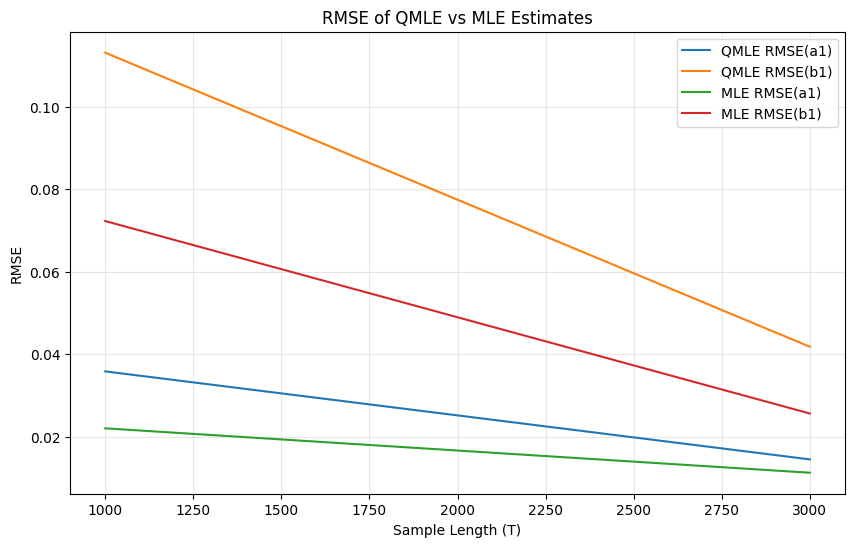

In [35]:
# Plot RMSEs
plt.figure(figsize=(10, 6))
for method in ["QMLE", "MLE"]:
    subset = df_results[df_results["Method"] == method]
    plt.plot(subset["T"], subset["RMSE_a1"], label=f"{method} RMSE(a1)")
    plt.plot(subset["T"], subset["RMSE_b1"], label=f"{method} RMSE(b1)")
plt.xlabel("Sample Length (T)")
plt.ylabel("RMSE")
plt.title("RMSE of QMLE vs MLE Estimates")
plt.legend()
plt.grid(alpha=0.3, linestyle='-')
plt.show()

### References

- Kogan, Leonid. *Volatility Models.* MIT Sloan School of Management, 15.450, Fall 2010.